In [1]:
import os
import numpy as np 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
### read data from files
features = torch.from_numpy(np.load('/home/xinyu.li/minghao.fu/xinyu-ncd/exp/cub/test/zs.npy'))
labels = torch.from_numpy(np.load('/home/xinyu.li/minghao.fu/xinyu-ncd/exp/cub/test/label.npy'))
num_classes = len(np.unique(labels))
num_samples = len(features)

ori_features = features.clone().detach()
mu_f = [features[labels==c].mean(0) for c in range(num_classes)]
std_f = [features[labels==c].std(0) for c in range(num_classes)]

In [4]:
k_top = 200 ### hyperparam
topk_ind = torch.stack([mu.topk(k=k_top).indices for mu in mu_f], dim=0)
mu_f = [features[labels==c].mean(0) for c in range(num_classes)]
std_f = [features[labels==c].std(0) for c in range(num_classes)]

##### visualization of topk distribution (deprecated)

In [6]:
num_classes, K = topk_ind.shape
overlap_ratio = torch.zeros((num_classes, num_classes))

for i in range(num_classes):
    for j in range(num_classes):
        intersection = len(set(topk_ind[i].tolist()) & set(topk_ind[j].tolist()))
        overlap_ratio[i, j] = intersection / K

# Result: overlap_ratio matrix
print("Pairwise Top-K Overlap Ratio:")
overlap_ratio.fill_diagonal_(0)
print(overlap_ratio)

Pairwise Top-K Overlap Ratio:
tensor([[0.0000, 0.1700, 0.2850,  ..., 0.3050, 0.2400, 0.2400],
        [0.1700, 0.0000, 0.1950,  ..., 0.1900, 0.2150, 0.2600],
        [0.2850, 0.1950, 0.0000,  ..., 0.2650, 0.5150, 0.4000],
        ...,
        [0.3050, 0.1900, 0.2650,  ..., 0.0000, 0.4300, 0.5950],
        [0.2400, 0.2150, 0.5150,  ..., 0.4300, 0.0000, 0.6500],
        [0.2400, 0.2600, 0.4000,  ..., 0.5950, 0.6500, 0.0000]])


In [7]:
conf_ind_top = overlap_ratio.topk(3).indices
conf_ind_low = (-overlap_ratio).topk(3).indices

##### synthesize feature with class-wise topk val replacement

In [9]:
from tqdm import tqdm
import random

method = ['instance', 'category'][0]
swap_method = ['a', 'b'][0]
mixed_features = torch.zeros([ori_features.size(0), num_classes, ori_features.size(1)]) ### output mixing feature: samples x classes x dimensions

for i in tqdm(range(ori_features.size(0))):
    line = ori_features[i].clone()
    class_a = labels[i]
    for class_b in range(num_classes):
        if method == 'instance':
            class_mask = torch.where(labels == class_b)
            sample_b = random.choice(class_mask[0]).item()
            feat_b = ori_features[sample_b]
        elif method == 'category':
            feat_b = mu_f[class_b]
        else:
            raise NotImplementedError()
        replace_ind = topk_ind[class_a if swap_method == 'a' else class_b]
        line[replace_ind] = feat_b[replace_ind]
        mixed_features[i, class_b] = line

100%|██████████| 4496/4496 [00:45<00:00, 98.82it/s] 


##### compute topk_ind to class_ind (deprecated)

In [38]:
from collections import defaultdict
index_to_classes = defaultdict(list)
for cls in range(num_classes):
    for ind in topk_ind[cls]:
        index_to_classes[ind.item()].append(cls)
        
index_to_classes = dict(index_to_classes)

In [42]:
index_to_classlen = {ind: len(cls_list) for ind, cls_list in index_to_classes.items()}

##### TSNE visualization

In [106]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np


def visualize_reduction(features, labels=None, method='tsne', n_components=2, **kwargs):
    """
    Reduce dimensionality using t-SNE, PCA, or UMAP and visualize.
    
    Parameters:
    - features (ndarray): Input features of shape (num_samples, feature_dim).
    - labels (ndarray or None): Labels for coloring points (optional).
    - method (str): Dimensionality reduction method ('tsne', 'pca', 'umap').
    - n_components (int): Number of reduced dimensions (default: 2).
    - kwargs: Additional arguments for the reduction method.
    
    Returns:
    - reduced_features (ndarray): Reduced feature array of shape (num_samples, n_components).
    """
    if isinstance(features, list):
        split_indices = [len(f) for f in features]
        features = torch.cat(features, dim=0)
    else:
        split_indices = None
    features_normalized = (features - features.mean(0)) / features.std(0)

    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30, n_iter=1500, **kwargs)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, **kwargs)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42, n_neighbors=15, min_dist=0.1, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'tsne', 'pca', 'umap'.")
    
    reduced_features = reducer.fit_transform(features_normalized)
    if split_indices:
        reduced_features_list = np.split(reduced_features, np.cumsum(split_indices)[:-1])

    plt.figure(figsize=(10, 8), dpi=128)
    if split_indices:
        markers = ['o', '^']
        for idx, reduced_features in enumerate(reduced_features_list):
            marker = markers[idx % len(markers)]  # Cycle markers if more than 2
            scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                                  c=labels, 
                                  cmap='tab10', 
                                  s=8, 
                                  alpha=0.7, 
                                  marker=marker, 
                                  edgecolor='black',
                                  linewidth=0.2,
                                  label=f"Features {idx + 1}")
    else:
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                               c=labels, cmap='tab10', s=5, alpha=0.7)
    if labels is not None:
        plt.colorbar(scatter, label='Labels')
    plt.title(f"{method.upper()} Visualization")
    plt.legend()
    plt.grid(True)
    plt.show()
    return reduced_features


In [ ]:
### visualization ablations
# random_classes = np.random.choice(np.unique(labels), size=20, replace=False)
# mask = np.isin(labels, random_classes)
# filtered_features = ori_features[mask]
# filtered_labels = labels[mask]

# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='tsne')
# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='pca')
# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='umap')


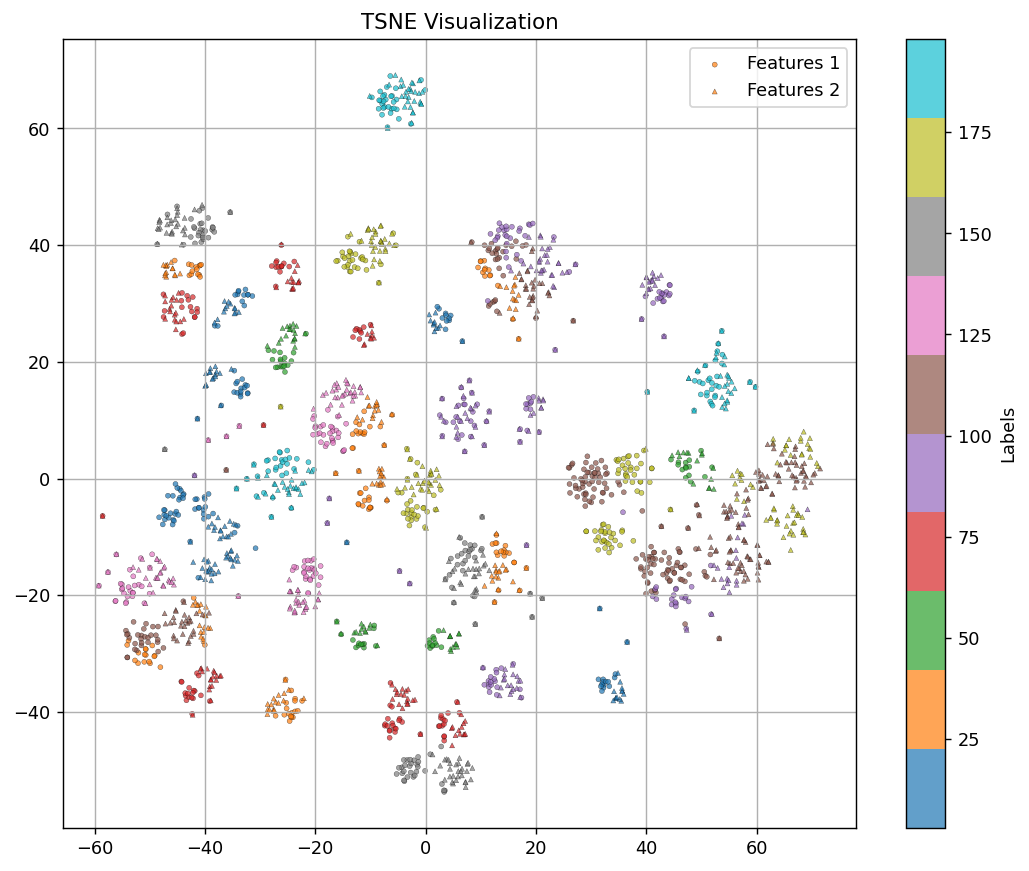

In [109]:
### subset classes for visualization
random_classes = np.random.choice(np.unique(labels), size=50, replace=False)
mask = np.isin(labels, random_classes)
filtered_features = mixed_features[mask]
filtered_labels = labels[mask]
filtered_conf_ind_top = conf_ind_top[filtered_labels]
filtered_conf_ind_low = conf_ind_low[filtered_labels]


features_2d = visualize_reduction([filtered_features[:, 0], filtered_features[:, 85]], labels=filtered_labels, method='tsne')
# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='pca')
# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='umap')


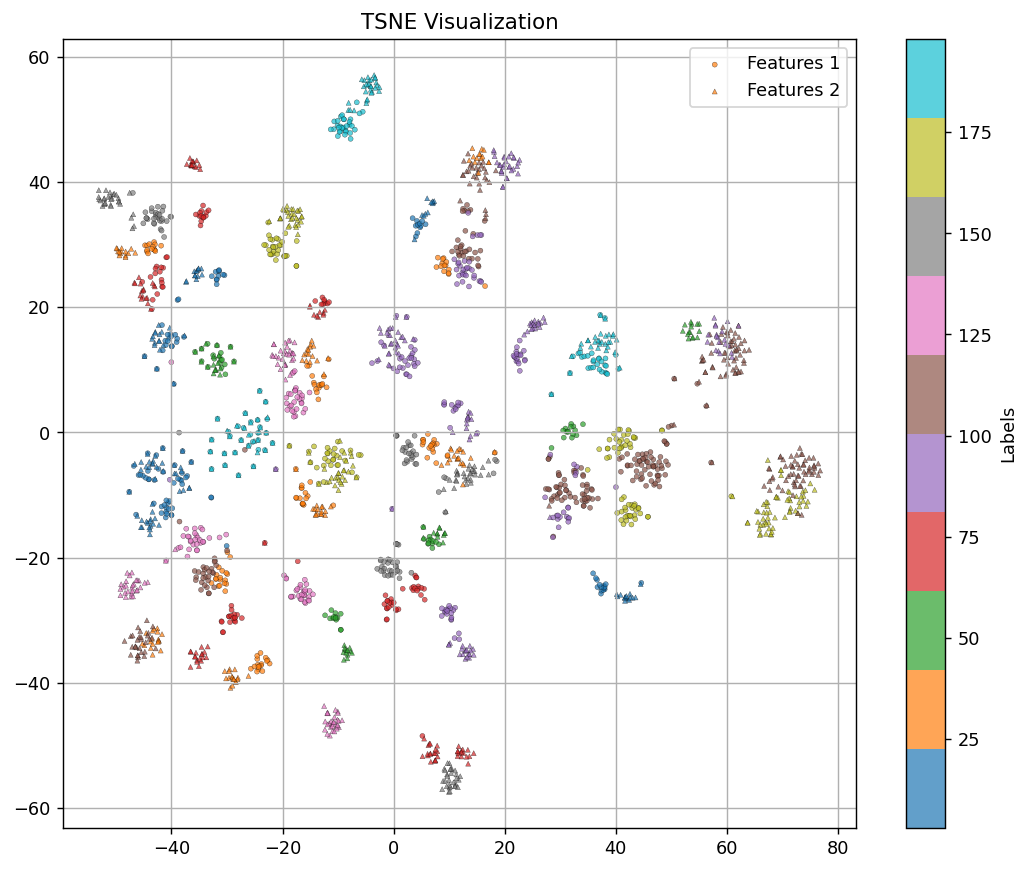

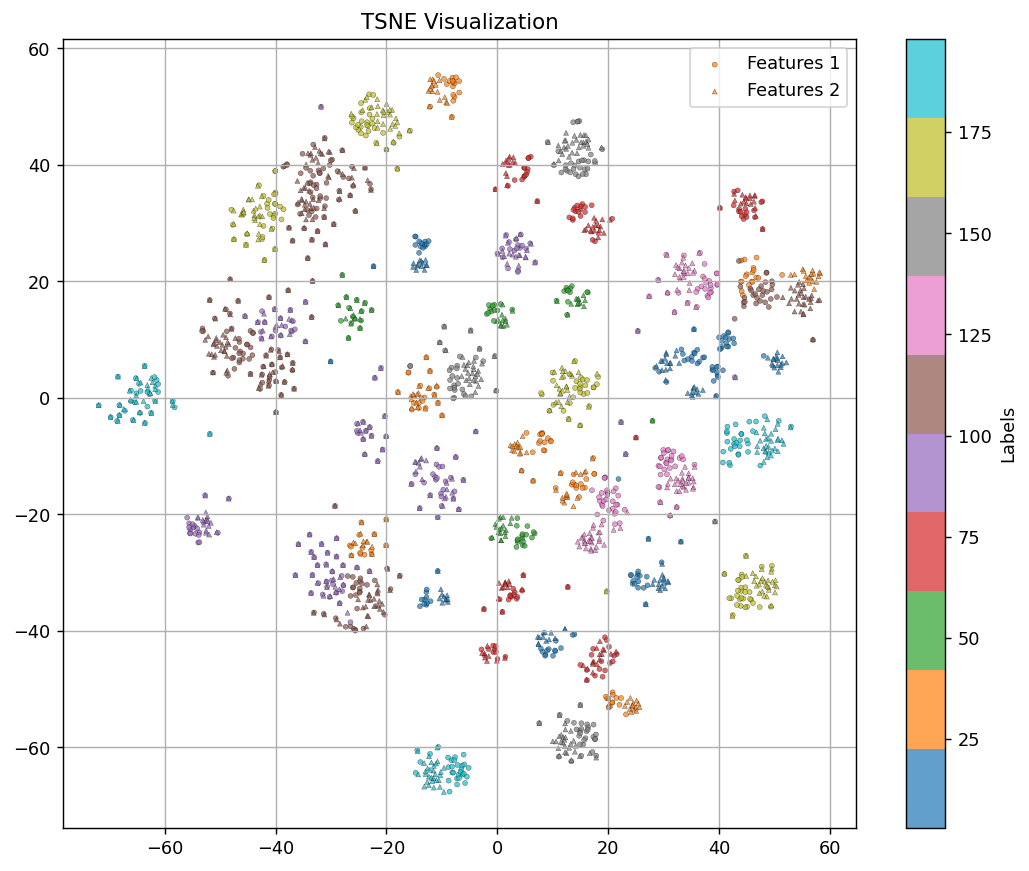

In [110]:
### design 1: high topk overlapping
features_2d = visualize_reduction([
    filtered_features[:, 0], 
    filtered_features[
    torch.arange(filtered_features.size(0)), 
    filtered_conf_ind_top[:, 0]]
], 
    labels=filtered_labels, method='tsne')

### design 2: low topk overlapping
features_2d = visualize_reduction([
    filtered_features[:, 0], 
    filtered_features[
    torch.arange(filtered_features.size(0)), 
    filtered_conf_ind_low[:, 1]]
], 
    labels=filtered_labels, method='tsne')
